# Pairs Trading strategy

In this notebook, we will create a strategy using a co-integration test and z-score. 
The strategy works as follows:
1. Read the daily data for Aluminium and Lead.
2. Define functions for co-integration, z-score, signal, and status generation.
3. Define functions for buy, sell price, and MTM calculations.
4. Execute the strategy on each day of the data and calculate the PnL.
5. Plot the data for Lead and Aluminium.
6. Plot the spread of log prices of Lead and Aluminium.

### Import libraries 

In [1]:
!pip install pyexcel

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\ayper\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# For data manipulations
import numpy as np
import pandas as pd

# To read, write, and manipulate data in excel formats
import pyexcel

# To perform statistical tests
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

# To plot
import matplotlib.pyplot as plt
%matplotlib inline

# For warnings
import warnings
warnings.filterwarnings('ignore')


### Initialise variables
Initialise trade status, MTM, stop loss, take profit and buy-sell prices to be used later in the strategy.

Note: Mark-to-Market is the fair value of a portfolio based on the market price of its constituents. You can read more about MTM <a href="https://m.economictimes.com/m/mark-to-market/articleshow/51209934.cms">here</a>.  

In [3]:
# Initialising variables
data = []
headers = ['Date', 'commodity1', 'commodity2', 'zscore', 'signal', 'status',
           'buy price', 'sell price', 'mtm', 'pnl', 'Cointegration test']

data.append(headers)

# Tolerance for the stdev above and below the mean
threshold = 2 # 1.75 iken

start = 30 # 80 iken 30 olunca daha iyi
end = 70   # 90 iken
prev_status = ""
mtm = ""
prev_sell_price = ""
sell_price = ""
prev_buy_price = ""
buy_price = ""
SL = -10000      
TP = 20000       

# Lot size for data1
N = 5000    
# Lot size for data2
M = 5000         

### Read data 
Read data for Aluminium and Lead from April 1, 2014, through July 1, 2016.

In [4]:
# Path to data folder
path = '../data/'

# Read the MCX Aluminium data
aluminium_price = pd.read_csv(
    path + 'MXC_AL_APR_2014_JULY_2016.csv', index_col='Date')

# Set the index to datetime format
aluminium_price.index = pd.to_datetime(aluminium_price.index)

# Read the MCX Lead data
lead_price = pd.read_csv(
    path + 'MXC_PB_APR_2014_JULY_2016.csv', index_col='Date')

# Set the index to datetime format
lead_price.index = pd.to_datetime(lead_price.index)

In [5]:
aluminium_price.to_csv("ALUMINUM.CSV")
lead_price.to_csv("LEAD.CSV")

### Clean up data and consider data for common dates only
1. Clean the fetched data
2. Merge two dataframes and select the data only corresponding to common data.
3. This will help us make a consistent analysis.

In [6]:
# Drop nan columns
aluminium_price = aluminium_price.dropna()
lead_price = lead_price.dropna()

# To make the data uniform date wise
aluminium_price['key'] = aluminium_price.index
lead_price['key'] = lead_price.index

# Merge dataframes to find common dates
result = pd.merge(aluminium_price, lead_price,
                  left_index=True, right_index=True)

aluminium_price = result[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x']]
lead_price = result[['Open_y', 'High_y', 'Low_y', 'Close_y', 'Volume_y']]

# Rename the columns
aluminium_price.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Rename the columns
lead_price.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

### Define cointegration test function
1. Run a linear regression on the input data to find the spread
2. Run a cointegration test on the fitted data to check for stationarity

In [7]:
# Define cointegration test function
def cointegration_test(x, y):
    
    # Use OLS method to find the spread of the two series
    result = stat.OLS(x['Close'], y['Close']).fit()
    
    # Check for stationarity of the spread using adfuller test
    return ts.adfuller(result.resid)

### Define z-score function for the spread
From start to endpoints for data1 and data2
1. Compute mean of the log of the ratio of close prices of the two price series
2. Compute the standard deviation of the log of the ratio of close prices of the two price series
3. Compute spread by taking the log of the ratio of prices of the two price series. Calculate the current spread only by taking the endpoints of the two data series
4. Compute the z-score by using the formula: (price- average)/(standard_deviation)


**Note:** The log-prices linearise the prices and give better estimation.

For example, if you consider a price change from 10 dollars to 20 dollars, on a linear scale this is simply 10 dollars. And a change from 20 dollars to 40 dollars is a change of 20 dollars (which is two times the previous case). But if you reconsider this, from 10 dollars to  20 dollars, there is a 100% increase. This is same as the change from 20 dollars to 40 dollars (100%). These changes are equivalent and would be represented by same vertical distance on a logarithmic scale. Therefore, the log of the prices are desired.

In [8]:
# Define z-score calculation function
def zscore_cal(data1, data2, start, end):

    s1 = pd.Series(data1['Close'][start:end])
    s2 = pd.Series(data2['Close'][start:end])

    # Compute mean of the spread till now
    mvavg_old = np.mean(np.log(s1/s2))

    # Compute stdev of the spread till now
    std_old = np.std(np.log(s1/s2))

    # Compute spread
    current_spread = np.log(
        data1['Close'][end]/data2['Close'][end])

    # This is the same as current_spread = np.log(data1['Close'][end]) - np.log(data2['Close'][end])

    # Compute z-score
    zscore = (current_spread - mvavg_old) / \
        std_old if std_old > 0 else 0

    return zscore

### Use the z-score function to generate trading signals
1. Generate a Sell signal when the z-score for the spread is greater than the threshold.
2. Similarly, generate a Buy signal when the z-score for the spread is smaller than the threshold.

In [9]:
# Generate trading signals
def signal_cal(zscore, threshold, adftest):
    
    # Z-score is greater than threshold, the spread shall fall towards mean
    if zscore > threshold and adftest == 'Yes':
        signal = 'SELL'  
        
    # Z-score is smaller than threshold, the spread shall rise towards mean
    elif zscore < -threshold and adftest == 'Yes':
        signal = 'BUY'  
    
    else:
        signal = ''

    return signal

### Update status for a trading day

1. Update status for a trading day as SL if MTM is less than SL
2. And as TP if MTM > TP
3. Check for cointegration break as well

SL = Stop Loss, TP = Take Profit, CB = Co-integration Break

In [10]:
# Define status
def status_cal(prev_status, mtm, SL, TP, signal, adftest):
    if prev_status in ["", "SL", "TP", "CB"]:
        status = signal
    else:
        if adftest == "No":
            # Break in the cointegration status of the pair
            status = "CB"   
        else:
            if mtm == "":
                status = ""
            else:
                if mtm < SL:
                    # Stop loss status
                    status = "SL"  
                else:
                    if mtm > TP:
                        # Take profit status
                        status = "TP"  
                    else:
                        status = prev_status

    return status

### Define buy price function

1. For a buy signal, close of the first security is the buy price
2. However, for a sell signal, close of the second security is the buy price

In [11]:
# Calculate buy price
def buy_price_cal(prev_status, prev_buy_price, buy_price, signal, status, data1, data2, end):

    if status == prev_status:
        buy_price = prev_buy_price

    else:
        if status in ["SL", "TP", "CB", ""]:
            buy_price = ""
        else:
            # Signal is to buy the spread
            if signal == "BUY":    
                # Hence, buy price = close of first security
                buy_price = data1['Close'][end]
            else:
                # Signal is to sell the spread
                if signal == "SELL":  
                    # Hence, buy price = close of second security
                    buy_price = data2['Close'][end]
                else:
                    # no signal hence no buy price
                    buy_price = ""   

    return buy_price

### Define sell price function

1. For a buy signal, close of the second security is the sell price
2. However, for a sell signal, close of the first security is the sell price

In [12]:
# Calculate sell price
def sell_price_cal(prev_status, prev_sell_price, sell_price, signal, status, data1, data2, end):
    if status == prev_status:
        sell_price = prev_sell_price
    else:
        if status in ["SL", "TP", "CB", ""]:
            sell_price = ""
        else:
            # Signal is to buy the spread
            if signal == "BUY":  
                # Hence sell price = close of second security
                sell_price = data2['Close'][end]
            else:
                if signal == "SELL":  # signal is to sell the spread
                    # Hence sell price = close of first security
                    sell_price = data1['Close'][end]
                else:
                    # No signal hence no sell price either
                    sell_price = ""  

    return sell_price

## Define MTM calculation function using lot sizes

N=5000: lot size for data1

M=5000: lot size for data2

In [13]:
# Calculate mtm
def mtm_cal(data1, data2, prev_status, prev_sell_price, prev_buy_price, M, N, end):

    if prev_status == "BUY":
        # Calculate mtm of the trades using their lot sizes
        mtm = (prev_sell_price-data2['Close'][end])*M + (data1['Close'][end] -
                                                         prev_buy_price)*N
    else:
        if prev_status == "SELL":
            # Calculate mtm of the trades using their lot sizes
            mtm = (prev_sell_price-data1['Close'][end])*N + (data2['Close'][end]
                                                             - prev_buy_price)*M
        else:
            mtm = ""

    return mtm

## Define strategy function 
1. Start from a look-back period of 90 days
2. Check for cointegration
3. Calculate z-score for the spread
4. Generate the signals
5. Calculate MTM for the day if applicable
6. Calculate Status, buy price and sell price
7. Calculate PnL

Save the dataframe as a CSV file for debugging purposes.

In [14]:
# Define the strategy function to execute the pairs trading program
def strategy(data1, data2, threshold, start, end, prev_status, mtm, prev_sell_price,
             sell_price, prev_buy_price, buy_price, SL, TP, M, N):
    pnl = 0
    i = 0
    for row in data1[90:].iterrows():

        # Run the ADF test for each day, starting from day 91
        d1 = data1[i:90+i]
        d2 = data2[i:90+i]
        c_t = cointegration_test(d1, d2)
        if c_t[0] <= c_t[4]['10%'] and c_t[1] <= 0.1:
            adftest = "Yes"
        else:
            adftest = "No"

        # Calculate z-score
        zscore = zscore_cal(data1, data2, start, end)

        # Generate trading signals
        signal = signal_cal(zscore, threshold, adftest)

        # Calculate mtm
        mtm = mtm_cal(data1, data2, prev_status, prev_sell_price,
                      prev_buy_price, M, N, end)

        # Assign status
        status = status_cal(prev_status, mtm, SL, TP, signal, adftest)

        # Assign buy_price
        buy_price = buy_price_cal(prev_status, prev_buy_price, buy_price,
                                  signal, status, data1, data2, end)

        # Assign sell_price
        sell_price = sell_price_cal(prev_status, prev_sell_price, sell_price,
                                    signal, status, data1, data2, end)

        # Calculate pnl
        pnl = (pnl + mtm) if status in ["TP", "SL", "CB"] else pnl

        # Assign prev values
        prev_sell_price = sell_price
        prev_status = status
        prev_buy_price = buy_price

        # Append calculations to the data array
        data.append([str(data1.index[end])[:10], data1['Close'][end],
                     data2['Close'][end], zscore, signal, status, buy_price,
                     sell_price, mtm, pnl, adftest])

        # Increment variables to consider the next set of data
        end = end+1
        start = start+1
        i = i+1

    # Save to a CSV for debugging
    pyexcel.save_as(
        array=data, dest_file_name='pair_strategy_without_zipline-90.csv')

### Plot Aluminium and Lead close prices

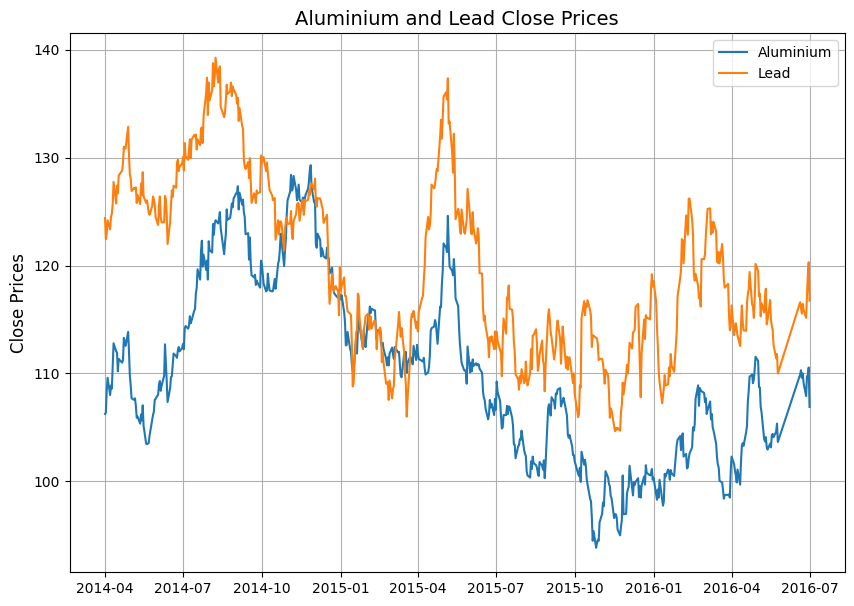

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot Closing price of data1
ax.plot(aluminium_price.index, aluminium_price.Close, label='Aluminium')

# Plot Closing price of data2
ax.plot(lead_price.index, lead_price.Close, label='Lead')

# Define labels for x-axis and y-axis
plt.legend()
plt.ylabel('Close Prices', fontsize=12)
plt.ylabel('Close Prices', fontsize=12)
plt.title('Aluminium and Lead Close Prices', fontsize=14)

# Display the major grid
plt.grid()

# Display the plot
plt.show()

### Plot the spread of Aluminium and Lead close prices

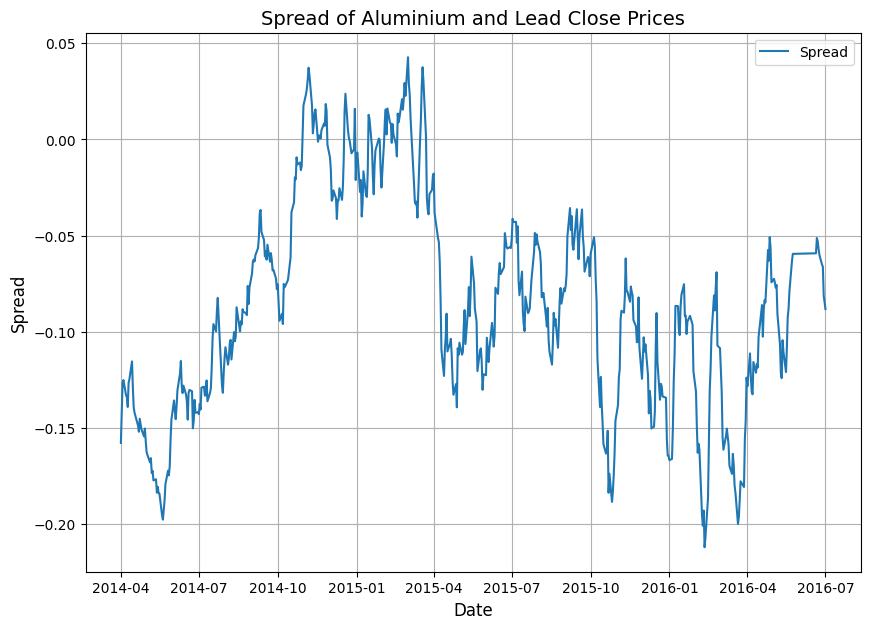

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot the spread
ax.plot(aluminium_price.index, np.log(
    aluminium_price.Close.values/lead_price.Close.values), label='Spread')

plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Spread', fontsize=12)
plt.title('Spread of Aluminium and Lead Close Prices', fontsize=14)
plt.grid()
plt.show()

### Plot the PnL

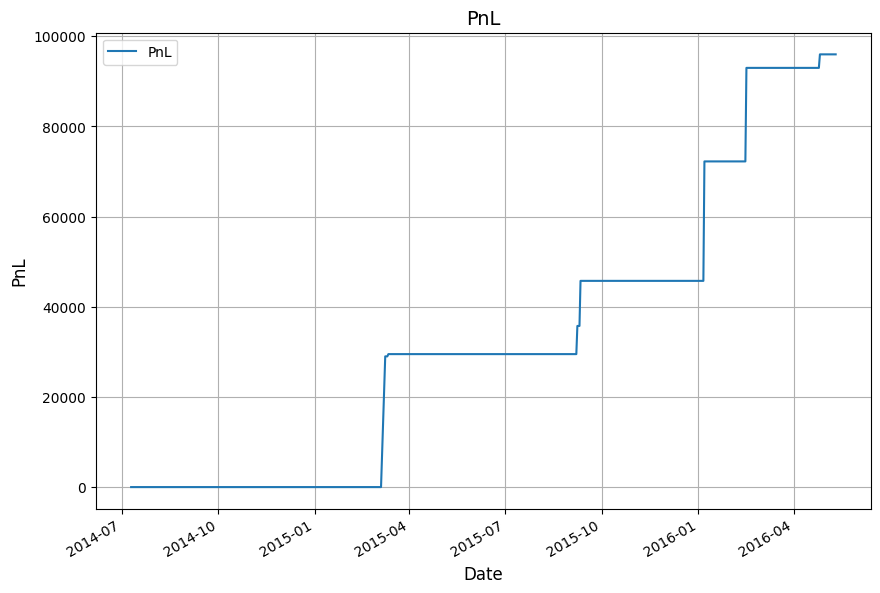

In [17]:
# Run the strategy
strategy(aluminium_price,lead_price,threshold,start,end,prev_status,mtm,prev_sell_price,\
             sell_price,prev_buy_price,buy_price,SL,TP,M,N) 

# Ignore the first row
result = pd.DataFrame(data, columns=headers)[1:] 

# Set Date column as index for better plotting
result.set_index('Date',inplace=True)  #

# Convert index to a datetime index
result.index = pd.to_datetime(result.index) 

result.pnl.plot(figsize=(10,7), label ='PnL') 
plt.legend() 
plt.xlabel('Date', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.title('PnL', fontsize=14)
plt.grid() 
plt.show()

As we can see, the strategy is profitable; however, the trade entry points are not entirely optimised yet. To optimise the entry points, we can use multiple indicators and optimise the threshold. We can also use leverage to enhance the PnL further.<br><br>